<p class="lead"> <b>Contenido</b> </p>

[1. Introducción](#1)  <br>
[2. Análisis exploratorio](#2)  <br>
&emsp;&emsp;[2.1 Importaciones y configuración](#2.1)  <br>
&emsp;&emsp;[2.2 Carga de datos](#2.2)  <br>
&emsp;&emsp;[2.3 Preprocesado del texto](#2.3)  <br>
&emsp;&emsp;&emsp;&emsp;[2.3.1 Normalizador de texto](#2.3.1)  <br>
&emsp;&emsp;[2.4 Análisis del corpus](#2.4)  <br>
&emsp;&emsp;&emsp;&emsp;[2.4.1 Nube de palabras](#2.4.1)  <br>
&emsp;&emsp;&emsp;&emsp;[2.4.2 Palabras más frecuentes](#2.4.2)  <br>
&emsp;&emsp;&emsp;&emsp;[2.4.3 Recuento de palabras](#2.4.3)  <br>
[3. Modelado](#3)  <br>
&emsp;&emsp;[3.1 Ingeniería de atributos](#3.1)  <br>
&emsp;&emsp;&emsp;&emsp;[3.1.1 Atributos indirectos](#3.1.1)  <br>
&emsp;&emsp;&emsp;&emsp;[3.1.2 Atributos directos](#3.1.2)  <br>
[4. Próximos pasos](#4) <br>

<a id="1"></a>
# 1. Introduccción

La importancia de la satisfacción del cliente radica en que nos ayuda a saber la probabilidad de que un cliente haga una compra a futuro. Pedir a los clientes que califiquen el grado de satisfacción es una buena forma de ver si se convertirán en clientes habituales o incluso en defensores de la marca.

En el presente proyecto crearemos un modelo de Machine Learning que predica el número de estrellas que recibiría un producto con base en el comentario que haya dejado un cliente. Para ello utilizaremos el dataset de reseñas de Amazon en español. 

<div class="alert alert-warning">
<b>The Multilingual Amazon Reviews Corpus</b> <br>
Se puede acceder al dataset <a href="https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX">aquí</a>. Es un comprimido .zip que contiene tres archivos .json. Más información sobre el dataset <a href="https://registry.opendata.aws/amazon-reviews-ml/">aquí</a>. Es importante que tengas en cuenta la <a href="https://docs.opendata.aws/amazon-reviews-ml/license.txt">licencia</a> de este dataset.
</div>

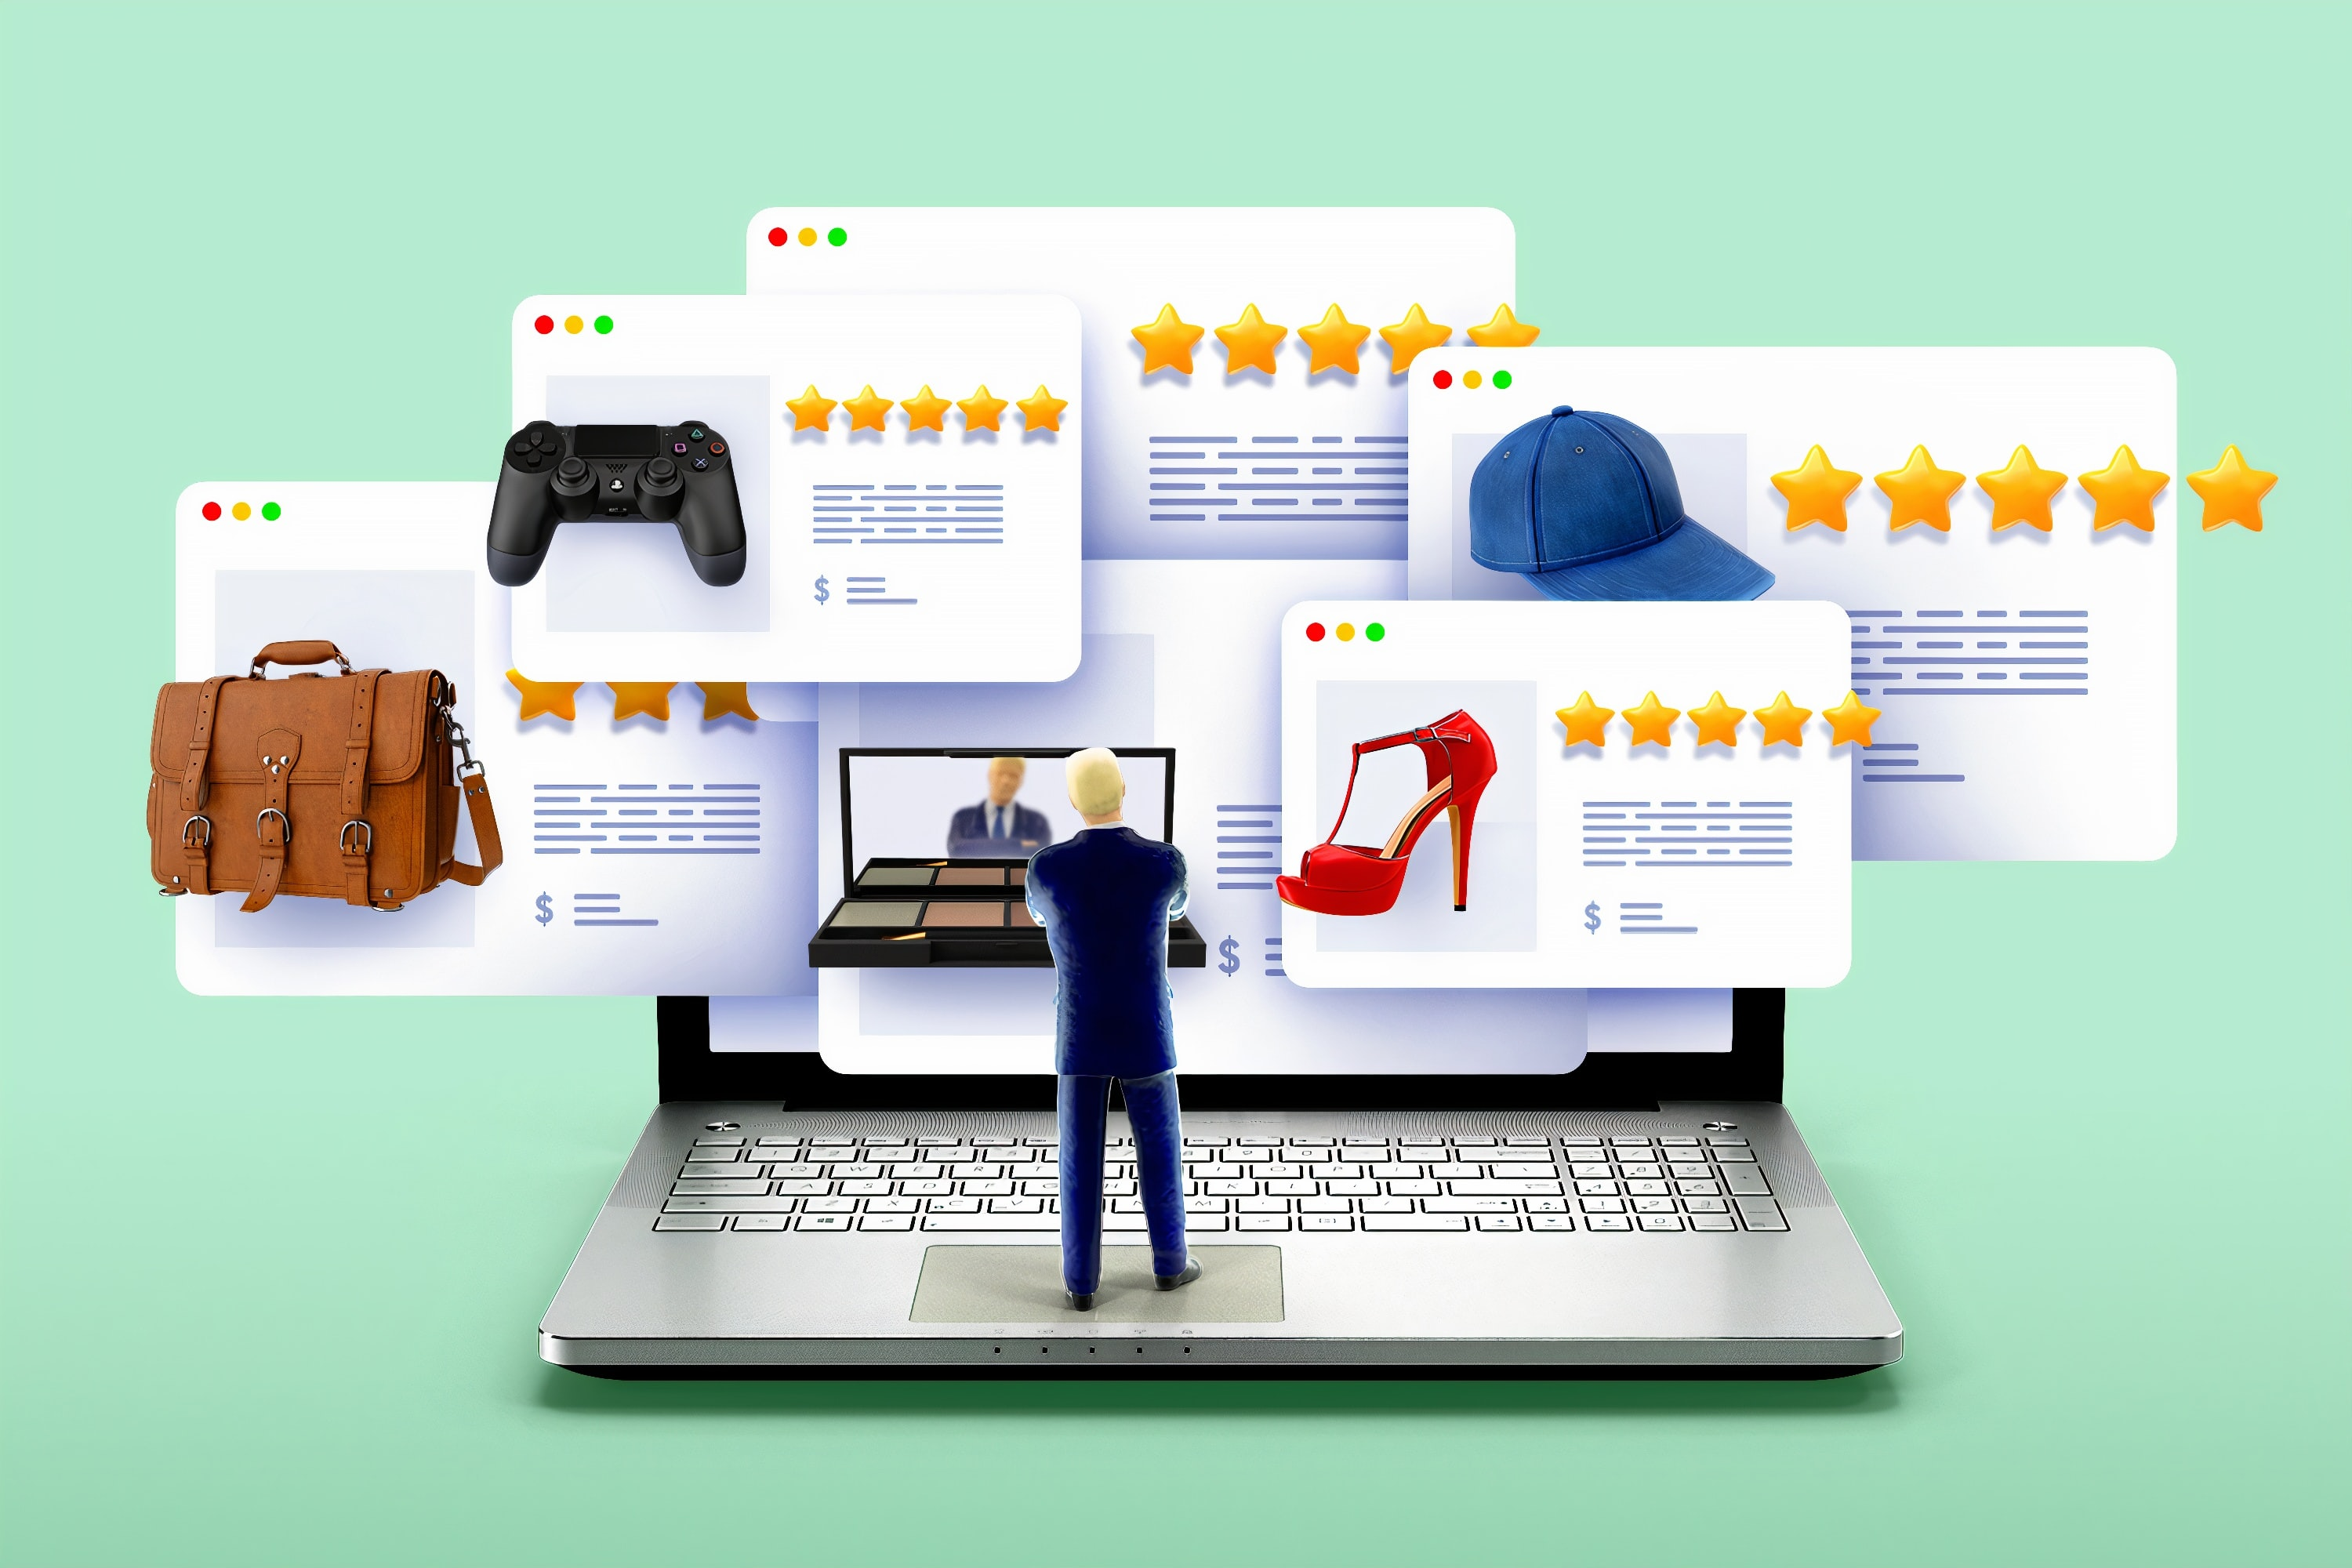

<span> Imagen de <a href="https://unsplash.com/@morningbrew?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Morning Brew</a> en <a href="https://unsplash.com/collections/12161642/nasturtium-tech?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

<a id="2"></a>
# 2. Análisis exploratorio

<a id="2.1"></a>
## 2.1 Importaciones y configuración 

Importamos las librerías necesarias

In [1]:
''' Data manipulation '''
import itertools
import numpy as np
import pandas as pd

'''Stats'''
import scipy.stats as ss
from scipy import sparse
from scipy.sparse import csr_matrix, hstack

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
%matplotlib inline 

''' NLP '''
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import spacy
nlp = spacy.load('es_core_news_lg') # Lematizador
import string
import unicodedata
from sentiment_analysis_spanish import sentiment_analysis

''' Machine Learning '''
# Preprocessing 
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
# Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

''' Misc '''
import gc 
from time import time

Using TensorFlow backend.


Configuramos el estilo de los gráficos

In [2]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'

# Cualitative colormap
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette,
        font='Gadugi', rc=params)

<a id="2.2"></a>
## 2.2 Carga de datos

Cargamos los datos

In [3]:
train = pd.read_json('data/dataset_es_train.json', lines=True)
test = pd.read_json('data/dataset_es_test.json', lines=True)
dev = pd.read_json('data/dataset_es_dev.json', lines=True)

In [4]:
print('Shape de Train:', train.shape)
print('Shape de Test:', test.shape)
print('Shape de Dev:', dev.shape)

Shape de Train: (200000, 8)
Shape de Test: (5000, 8)
Shape de Dev: (5000, 8)


El set de _Train_ contiene 200 mil reseñas, mientras que _Test_ y _Dev_, 5 mil cada uno. Para este proyecto usaremos el set _Train_ y _Dev_ para entrenar los modelos y optimizar hiperparametros, mientras _Test_ lo usaremos al final, para tener una idea de como funcionaría nuestro modelo elegido en el mundo real. 

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_id         200000 non-null  object
 1   product_id        200000 non-null  object
 2   reviewer_id       200000 non-null  object
 3   stars             200000 non-null  int64 
 4   review_body       200000 non-null  object
 5   review_title      200000 non-null  object
 6   language          200000 non-null  object
 7   product_category  200000 non-null  object
dtypes: int64(1), object(7)
memory usage: 12.2+ MB


In [6]:
train.head(8)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
5,es_0779978,product_es_0103315,reviewer_es_0304973,1,Jamás me llegó y el vendedor nunca contacto co...,Jamás me llegó,es,home
6,es_0591840,product_es_0880915,reviewer_es_0642702,1,"El paraguas es de muy mala calidad,da la sensa...",Horroroso!!!,es,luggage
7,es_0173297,product_es_0814677,reviewer_es_0895784,1,Tuve que devolverla porque al ser triangular n...,Poco funcional,es,office_product


In [7]:
train.describe(include='all')

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
count,200000,200000,200000,200000.000000,200000,200000,200000,200000
unique,200000,150938,179076,NaN,198264,112114,1,30
top,es_0903168,product_es_0261843,reviewer_es_0431022,NaN,Buena relación calidad precio,Bien,es,home
freq,1,8,7,NaN,106,1952,200000,26962
mean,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.414217,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN


De las anteriores celdas podemos obtener la siguiente información de las columnas:
- **review_id:** es atributo único para cada reseña, por lo que será inútil para entrenar el modelo.
- **product_id:** es un atributo único para cada producto, hay al menos 150 mil productos diferentes en el dataset.
- **reviewer_id:** es el código único de cada usuario, hay al menos 179 mil usuarios diferentes.
- **stars:** única variable numérica del dataframe, es discreta (toma valores entre 1 y 5) y es nuestro ***target***.
- **review_body:** es el cuerpo de la reseña o crítica del producto comprado, será nuestro atributo principal para predecir.
- **review_title:** es el título de la reseña, también contiene información útil para predecir el número de estrellas.
- **language:** es el idioma de la reseña, en este caso, todas están en español de modo que esta columna no aporta al modelo.
- **product_category:** es la categoría del producto evaluado, hay 30 categorías diferentes siendo _home_ la más frecuente.

Ahora checamos si hay valores faltantes

In [8]:
train.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

In [9]:
dev.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

Contamos los reseñas por cada estrella

In [10]:
train.stars.value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In [11]:
dev.stars.value_counts()

3    1000
2    1000
5    1000
1    1000
4    1000
Name: stars, dtype: int64

Notamos que los datasets están balanceados en cuanto a cada estrella.

In [12]:
n_ratings = np.arange(1, 9)
n_products = []
for n in n_ratings:
    n_products.append(np.sum(train.groupby(by='product_id').count() >= n)[0])

Text(0.5, 0, 'Número mínimo de reseñas')

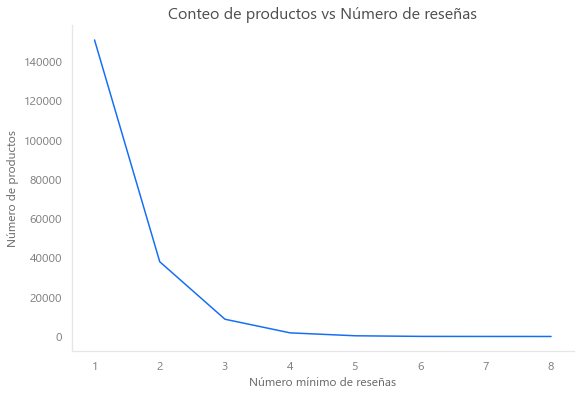

In [13]:
plt.figure(figsize=(9, 6))
plt.plot(n_ratings, n_products)
plt.title('Conteo de productos vs Número de reseñas')
plt.ylabel('Número de productos')
plt.xlabel('Número mínimo de reseñas')

Un gran porcentaje de los productos solo tiene una reseña, y la gran mayoría no superan las 3 reseñas.

In [14]:
def put_labels(X, text_format='{:,}', fontsize=12):
    '''
    Función para colocar labels en las barras
    '''
    padding = max(X) * 0.01
    for i, val in enumerate(X):
        ax.text(x=X[i]+padding,
                y=i,
                s=text_format.format(X[i]),
                va='center',
                ha='left',
                color='0.6',
                weight='bold',
                fontsize=fontsize)

In [15]:
def change_height(ax, new_value):
    '''
    Función para modificar la altura de las barras
    '''
    for patch in ax.patches:
        current_height = patch.get_height()
        diff = current_height - new_value
        # change the bar height
        patch.set_height(new_value)
        # recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

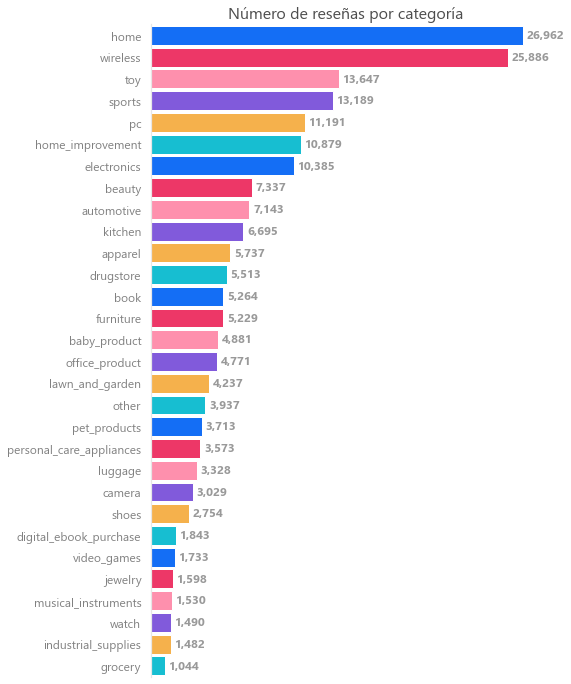

In [16]:
#Hallamos el número de reseñas por categoría
category = train['product_category'].value_counts()

# Creamos el gráfico
plt.figure(figsize=(7, 12))
ax = sns.barplot(x=category.values, 
                 y=category.index,
                 palette=palette, 
                 orient='h',
                 saturation=1,
                )

change_height(ax, 0.87)
put_labels(category)
ax.set_title('Número de reseñas por categoría')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)

Explorando el atributo `product_category` nos damos cuenta que, al igual que en la vida real, en nuestro datasets hay que categorías con más reseñas que otras. 

Y es que el comercio electronico normalmente es usado para comprar aquellas cosas que no podemos conseguir tan facilmente en nuestro entorno, como por ejemplo productos de tecnología, libros, elementos del hogar. Mientras que aquellos que se pueden conseguir en cualquier supermercado o almacén las personas prefieren dirigirse fisicamente, bien por practicidad, por ahorrar costos de envío o para asegurarse de que sí se ajuste a sus preferencias (ropa, zapatos, accesorios).



In [17]:
mean_rating = train.groupby(by=['product_category', 'product_id']).agg({'stars': ['mean']})
mean_rating.columns = ['stars_mean']
mean_rating = mean_rating.reset_index()

In [18]:
def color_boxplot(ax):
    '''
    Función para cambiar el color de las líneas del boxplot
    '''
    for i, artist in enumerate(ax.artists):
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

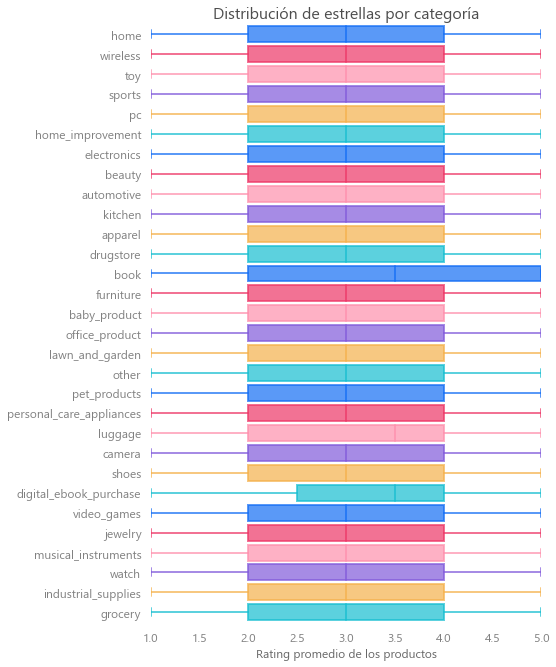

In [19]:
plt.figure(figsize=(7, 11))

ax = sns.boxplot(y=mean_rating['product_category'], 
                 x=mean_rating['stars_mean'],
                 order=category.index,
                 orient='h',
                 palette=palette,
                 saturation=1, 
                 whis=1.5, 
                 linewidth=2, 
                 boxprops=dict(alpha=.7)
                )

for i, artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

ax.set_title('Distribución de estrellas por categoría')
ax.set_xlabel('Rating promedio de los productos')
ax.set_xlim(1, 5)
ax.set_ylabel('')
sns.despine(left=True, bottom=True)

Se puede observar en los boxplots que el rating promedio de los productos de las diferente categoría es bastante similar en el dataset. Solo destacan algunas categorías cuyo rating medio es mayor que 3: libros, equipaje (maletas) y libros electronicos. 

No alcanzo a divisar la razón por la que la categoría de equipaje (luggage) tiene un mayor rating promedio, pero en cuanto a los libros está claro: las personas antes de comprar un libro pueden leer la sinopsis y si les ineteresa el autor, la categoría o el contenido, lo compran. Se puede decir que la expectativas del cliente respecto a un libro tienden a estar mucho más cerca al contenido real de este. Sumado a esto, hay que considerar que en el caso de los libros electrónicos no hay un proceso logístico de transporte, por lo que un buena parte de las razones de colocar 1 o 2 estrellas desaparece. 

In [20]:
mean_rating_cat = mean_rating.groupby('product_category').mean().sort_values(
                            by='stars_mean', ascending=False).reset_index()

print('Categorías mejor calificadas:')
display(mean_rating_cat.head(5))
print('\nCategorías peor calificadas:')
display(mean_rating_cat.tail(5))

Categorías mejor calificadas:


,product_category,stars_mean
0,book,3.407773
1,digital_ebook_purchase,3.387216
2,luggage,3.322772
3,musical_instruments,3.235620
4,grocery,3.190638



Categorías peor calificadas:


,product_category,stars_mean
25,jewelry,2.958474
26,electronics,2.924371
27,apparel,2.881699
28,wireless,2.863935
29,lawn_and_garden,2.811259


Y vemos que en las categorías con menor rating son aquellas que tienen productos con altos costos, como joyería y electrónicos. Esto muestra que las personas tienden a ser más críticas con los productos más costosos. La categoría `apparel`, que se refiere a vestidos, también muestra un tendencia a comentarios negativos puesto que la ropa no siempre cumple las expectavitas de las personas porque estás no pueden de antemano evaluar su calidad, textura o ajuste.

In [21]:
cross = pd.crosstab(train.product_category, train.stars, normalize='index')
cross

stars,1,2,3,4,5
product_category,,,,,
apparel,0.221893,0.210040,0.209169,0.197141,0.161757
automotive,0.212096,0.194456,0.207896,0.201736,0.183816
baby_product,0.170047,0.197705,0.216349,0.204671,0.211227
beauty,0.210713,0.208123,0.209759,0.177457,0.193948
book,0.125190,0.170213,0.189590,0.210106,0.304901
camera,0.176956,0.186200,0.199406,0.225487,0.211951
digital_ebook_purchase,0.098752,0.172545,0.240369,0.249593,0.238741
drugstore,0.202612,0.197352,0.199710,0.187557,0.212770
electronics,0.231295,0.210688,0.183149,0.188830,0.186038


In [22]:
stars = [1, 2, 3, 4, 5]
for star in stars:
    print('⭐'*star)
    print('Mean: {:.2f} (+/-{:.2f})'.format(
        cross.iloc[:, star-1].mean(), cross.iloc[:, star-1].std()))
    if star < 5:
        print('')

⭐
Mean: 0.19 (+/-0.03)

⭐⭐
Mean: 0.19 (+/-0.01)

⭐⭐⭐
Mean: 0.20 (+/-0.01)

⭐⭐⭐⭐
Mean: 0.20 (+/-0.02)

⭐⭐⭐⭐⭐
Mean: 0.21 (+/-0.03)


Dependiendo de la categoría la proporción del número de estrellas cambia, pero en general cada estrella ocupa entre 19% y el 21% de cada categoría.

<a id="2.3"></a>
## 2.3 Preprocesado

Antes separemos los datasets de entrenamiento y validación en X e y.

In [23]:
columns = ['review_body', 'review_title', 'stars']

train_ml = train[columns].copy()
dev_ml = dev[columns].copy()
test_ml = test[columns].copy()

In [24]:
train_ml.head()

,review_body,review_title,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1
4,Llega tarde y co la talla equivocada,Devuelto,1


**Removiendo acentos**

En el español, la personas no suelen escribir con acentos en asuntos informales, a menos que el autocorrector lo haga por ellos. Por eso llevaremos todas las palabras a su versión sin acentos ortográficos (tildes).

In [25]:
def remove_accented(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [26]:
remove_accented('El niño está comiendo puré desde la antigüedad')

'El nino esta comiendo pure desde la antiguedad'

**Removiendo caracteres irrelevantes**

In [27]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+' if not remove_digits else r'[^ \nA-Za-zÀ-ÖØ-öø-ÿ/]+'
    text = re.sub(pattern, '', text)
    return text

In [28]:
remove_special_characters('¡¿éste es un mensaje, de Prueba?!13#$', remove_digits=False)

'éste es un mensaje de Prueba13'

**Eliminación de stopwords**

In [29]:
stopword_list = nltk.corpus.stopwords.words('spanish')

# Removemos algunas stopwords que consideramos importantes para los bigramas
stops = ['sí', 'no', 'ni', 'sin', 'muy', 'mucho', 'muchos']
for i in stops:
    stopword_list.remove(i)

In [30]:
tokenizer = ToktokTokenizer()

def remove_stopswords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [31]:
remove_stopswords('El zorro café se comió una gallina, ahora salta sobre el perro peresozo sin esfuerzo.')

'zorro café comió gallina , ahora salta perro peresozo sin esfuerzo .'

**Lematización**

In [32]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [33]:
lemmatize_text('Los hijos de ellos son divertidos, y además juegan fútbol')

'Los hijo de ellos ser divertir , y además jugar fútbol'

Probemos eliminar stopswords y lematizando despues

In [34]:
original = 'El zorro café se comio una gallina y ahora salta sobre el perro peresozo sin esfuerzo.'
new = remove_stopswords(original)
new = lemmatize_text(new)
print(original)
print(new)

El zorro café se comio una gallina y ahora salta sobre el perro peresozo sin esfuerzo.
zorro café comio gallina ahora saltar perro peresozo sin esforzar .


La lematización no funciona muy bien cuando la palabras no llevan los acentos donde corresponde: en este caso no fue capaz de transformar 'comio' en 'comer'. Por lo que optaremos por hacer la lematización anter de quitar tildes a las letras.

<a id="2.3.1"></a>
### 2.3.1 Normalizador de texto

Ahora creamos la función que integrará todo el proceso de normalización.

In [35]:
def normalize_corpus(corpus):
    '''
    Aplica todo el preprocesado al texto ingresado.    
    
    '''
    normalized_corpus = []
    
    for doc in corpus:
        # pone el texto en minúscula
        doc = doc.lower()
        # remueve nuevas líneas extras
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
        # remueve stopswords
        doc = remove_stopswords(doc)
        # remueve caracteres especiales y números 
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=True)
        # remueve espacios extras
        doc = re.sub(' +', ' ', doc)
        # lematiza
        doc = lemmatize_text(doc)
        # remueve tildes, dieresis y virgulillas
        doc = remove_accented(doc)
        
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [36]:
text = ['El zorro café se comió 1 (una) gallina y ahora salta sobre el perro peresozo sin esfuerzo.', 
        'Muy bien. El producto está en perfectas condiciones.']
norm_text = normalize_corpus(text)

for i, j in zip(text, norm_text):
    print(i)
    print(j)
    print()

El zorro café se comió 1 (una) gallina y ahora salta sobre el perro peresozo sin esfuerzo.
zorro cafe comer gallina ahora saltar perro peresozo sin esforzar

Muy bien. El producto está en perfectas condiciones.
muy bien producto perfecto condicionar



¡Pongamosla en acción en el dataset! Primero, combinaremos el título y el cuerpo de la reseña para formar un solo texto para cada comentario. Luego le haremos el preprocesado.

In [37]:
# Combinamos el título y el cuerpo 
train_ml['full_text'] = train_ml['review_title'].map(str)+ '. ' + train_ml['review_body']

In [38]:
train_ml.head()

,review_body,review_title,stars,full_text
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1,television Nevir. Nada bueno se me fue ka pant...
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1,Dinero tirado a la basura con esta compra. Hor...
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1,solo llega una unidad cuando te obligan a comp...
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1,PRODUCTO NO RECIBIDO.. No entro en descalifica...
4,Llega tarde y co la talla equivocada,Devuelto,1,Devuelto. Llega tarde y co la talla equivocada


In [39]:
# Lo mismo para los otros datasets
dev_ml['full_text'] = dev_ml['review_title'].map(str)+ '. ' + dev_ml['review_body']
test_ml['full_text'] = test_ml['review_title'].map(str)+ '. ' + test_ml['review_body']

Antes de pasar la función de normalización, probemos con algunas features al azar.

In [40]:
# Checamos una reseña al azar
np.random.seed(100)
index_random = np.random.randint(0, train_ml.shape[0], 3)
corpus = train_ml.iloc[index_random].full_text.values
norm_corpus = normalize_corpus(corpus)


def imprime_lado_a_lado(a, b, size=30, space=4):
    while a or b:
        print(a[:size].ljust(size) + " " * space + b[:size])
        a = a[size:]
        b = b[size:]

imprime_lado_a_lado('FULL', 'CLEAN', 52, 4)
print('—' * 108)
for i, j in enumerate(corpus):
    imprime_lado_a_lado(corpus[i], norm_corpus[i], 52, 4)
    print('-' * 108)


FULL                                                    CLEAN
————————————————————————————————————————————————————————————————————————————————————————————————————————————
La entrega deja mucho que desear... Me he encontrado    entregar dejar mucho desear encontrar paquete abrir 
 el paquete abierto y sujeto con el catálogo de Ikea    sujetar catalogo ikea salir buzon desastre suerte no
 saliendo del buzón. Un desastre!! Suerte que no ha      desaparecer
desaparecido                                            
------------------------------------------------------------------------------------------------------------
Tapa deteriorada. Me llego el libro adecuado, pero l    tapar deteriorar llegar librar adecuar tapar muy det
a tapa muy deteriorada. Era para un regalo, por lo n    eriorar regalar no posibilidad solicitar cambiar
o tuve posibilidad de solicitar el cambio.              
---------------------------------------------------------------------------------------------------------

Parece que todo anda bien por aquí, es hora normalizar todos los datasets.

In [41]:
try:
    train_ml = pd.read_csv('processed_data/train.csv')
except:
    # Preprocesamos Train
    train_ml['clean_text'] = normalize_corpus(train_ml['full_text'])
    # Guardamos el dataset en memoria para en el futuro simplemente cargarlo.
    train_ml.to_csv('processed_data/train.csv', index=False, encoding='utf-8')

In [42]:
train_ml.head()

,review_body,review_title,stars,full_text,clean_text
0,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,1,television Nevir. Nada bueno se me fue ka pant...,television nevir bueno ka pantalla menos mesar...
1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,1,Dinero tirado a la basura con esta compra. Hor...,dinero tirar basura comprar horrible comprar n...
2,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,1,solo llega una unidad cuando te obligan a comp...,solo llegar unidad obligar comprar do obligar ...
3,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,1,PRODUCTO NO RECIBIDO.. No entro en descalifica...,producto no recibir no entrar descalificar ven...
4,Llega tarde y co la talla equivocada,Devuelto,1,Devuelto. Llega tarde y co la talla equivocada,devolver llegar tardar co tallar equivocar


Preprocesamos Dev

In [43]:
try:
    dev_ml = pd.read_csv('processed_data/dev.csv')
except:
    dev_ml['clean_text'] = normalize_corpus(dev_ml['full_text'])
    dev_ml.to_csv('processed_data/dev.csv', index=False, encoding='utf-8')

In [44]:
dev_ml.head()

,review_body,review_title,stars,full_text,clean_text
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1,"Mala compra. Malisimo, muy grande demasiado ap...",malo comprar malisimo muy grande demasiar apar...
1,No he recibido el pedido no la devolución,No lo he recibido,1,No lo he recibido. No he recibido el pedido no...,no recibir no recibir pedir no devolucion
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1,Que no aprieta bien en el manillar. Tengo que ...,no apretar bien manillar buscar sistema no fun...
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1,Brocas de mantequilla. Utilicé las brocas de m...,broca mantequilla utilizar broca menor diametr...
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1,No me gusta. No me gusta su olor a viejo y asp...,no gustar no gustar olor viejo aspecto malo


Preprocesamos Test

In [45]:
try:
    test_ml = pd.read_csv('processed_data/test.csv')
except:
    test_ml['clean_text'] = normalize_corpus(test_ml['full_text'])
    test_ml.to_csv('processed_data/test.csv', index=False, encoding='utf-8')

In [46]:
test_ml.head()

,review_body,review_title,stars,full_text,clean_text
0,no me llego el articulo me lo mando por correo...,no me llego,1,no me llego. no me llego el articulo me lo man...,no llegar no llegar articular mandar correo no...
1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,1,amazon sigue sin cumplir en las entregas. la m...,amazon seguir sin cumplir entregar mensajeria ...
2,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,1,ESTAFA EN EL ENVÍO. Estoy muy decepcionado con...,estafar enviar muy decepcionar vendedor pedir ...
3,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,1,Estafa de Amazon. Mi valoración no es sobre el...,estafar amazon valoracion no producto sino ama...
4,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,1,No conseguí pasar de la portada en Kindle. Pue...,no conseguir pasar portar kindle pues interes ...


<a id="2.4"></a>
## 2.4 Análisis del corpus

Ahora que hemor normalizado el dataset podemos empezar a hacer la exploración del texto propiamente. Empezaremos graficando una nube de palabras general, y una para cada polaridad (comentarios positivos y negativos). Luego entraremos en detalle sobre cuales palabras son frecuentes en cada escala del rating. 

Y finalmente analizaremos el texto para hallar el conteo que letras en mayúsculas, de signos de exclamación o directamente el número de palabras. De encontrar diferencias signifcativas entre las clases podríamos pensar en utilizar estos datos como atributos indirectos de entrada al modelo.

<a id="2.4.1"></a>
### 2.4.1 Nube de palabras

In [47]:
subset = train_ml.copy()

In [48]:
text = ' '.join(review for review in subset['full_text'])
print('Hay {:,} palabras al combinar todas las reseñas del dataset.'.format(len(text)))

Hay 34,694,547 palabras al combinar todas las reseñas del dataset.


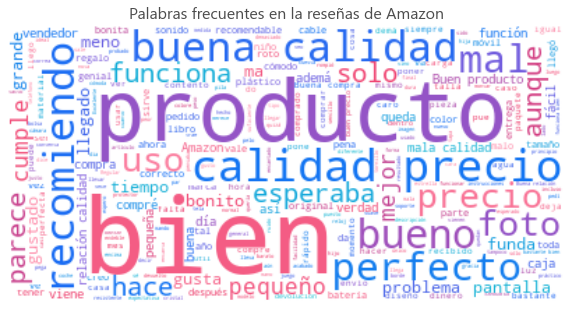

In [49]:
stopword_cloud = nltk.corpus.stopwords.words('spanish')
stopword_cloud.append('si')

wc = WordCloud(max_words=500, stopwords=stopword_cloud, background_color='white', random_state=100)
wc.generate(text)

plt.figure(figsize=(10, 8))
plt.imshow(wc.recolor(colormap=rainbow, random_state=100), interpolation='bilinear')
plt.title('Palabras frecuentes en la reseñas de Amazon')
plt.axis('off')
plt.show()

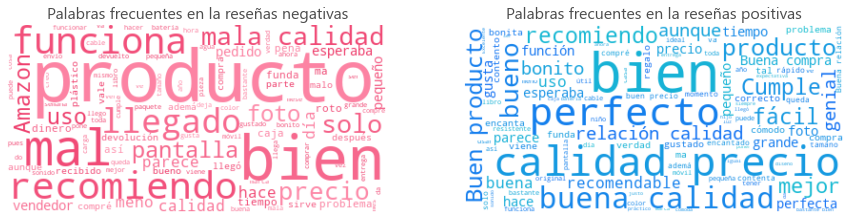

In [50]:
plt.figure(figsize=(15, 8))

# Comentarios negativos
subset_neg = subset[subset['stars'].isin([1, 2])].copy()
text_neg = ' '.join(review for review in subset_neg['full_text'])

wc_neg = WordCloud(max_words=100, stopwords=stopword_cloud, background_color='white', random_state=100)
wc_neg.generate(text_neg)

plt.subplot(121)
plt.imshow(wc_neg.recolor(colormap=redpink, random_state=100), interpolation='bilinear')
plt.title('Palabras frecuentes en la reseñas negativas')
plt.axis('off')


# Comentarios positivos
subset_pos = subset[subset['stars'].isin([4, 5])].copy()
text_pos = ' '.join(review for review in subset_pos['full_text'])

wc_pos = WordCloud(max_words=100, stopwords=stopword_cloud, background_color='white', random_state=100)
wc_pos.generate(text_pos)

plt.subplot(122)
plt.imshow(wc_pos.recolor(colormap=bluemint, random_state=100), interpolation='bilinear')
plt.title('Palabras frecuentes en la reseñas positivas')
plt.axis('off')
plt.show()

<a id="2.4.2"></a>
### 2.4.2 Palabras más frecuentes

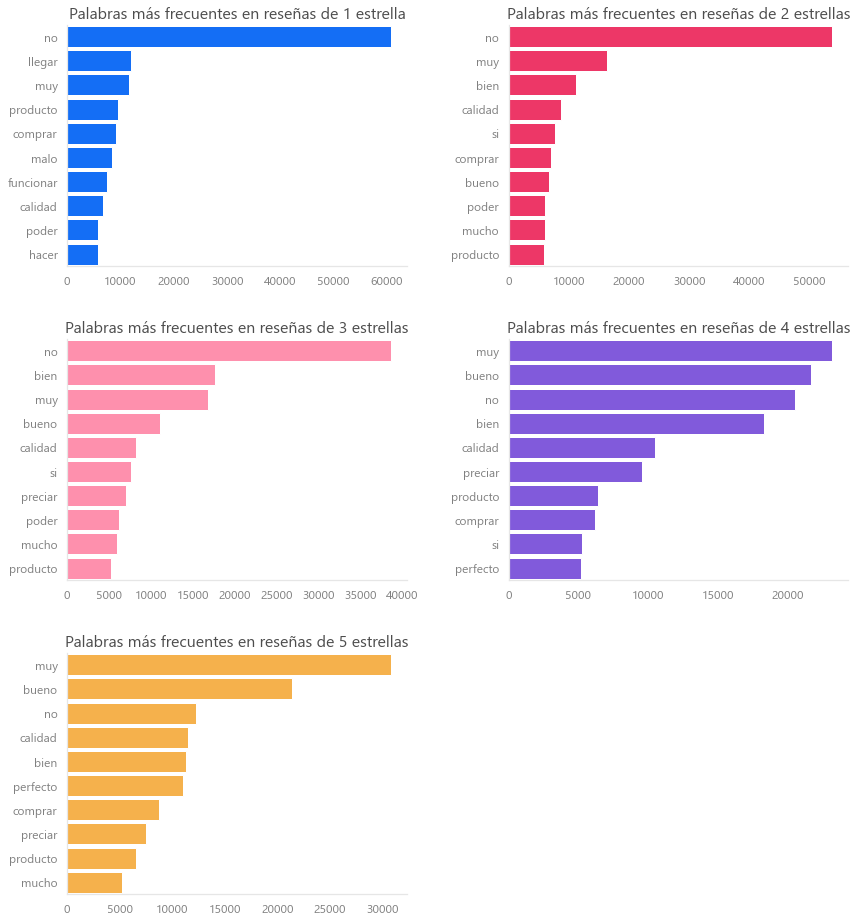

In [51]:
plt.figure(1, figsize=(14, 16))

stars = [1, 2, 3, 4, 5]

for i in stars:   
    subset_ = subset.query('stars == {}'.format(i))
    reviews = []
    
    # Cargamos reseñas tokenizadas a la lista
    for j in range(subset_.shape[0]):
        review = subset_.iloc[j].clean_text
        review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
        reviews.append(review)
    
    # 'Aplanamos' la lista
    reviews = list(itertools.chain(*reviews))
    
    # Sacamos las frecuencias
    freq = nltk.FreqDist(reviews)
    
    # Convertimos en DataFrame
    df_freq = pd.DataFrame(list(freq.items()), columns=["Word","Frequency"])
    df_freq.sort_values('Frequency', ascending=False, inplace=True)
    df_freq.reset_index(drop=True, inplace=True)
    
    # Graficamos 
    plt.subplot(3, 2, i)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = sns.barplot(x=df_freq.iloc[:10].Frequency,
                     y=df_freq.iloc[:10].Word,
                     color=palette[i-1],
                     orient='h',
                     saturation=1)
    change_height(ax, 0.87)
    ax.set_title('Palabras más frecuentes en reseñas de {} estrella{}'
                 .format(i, '' if i==1 else 's'))
    ax.set_xlabel('')
    ax.set_ylabel('')

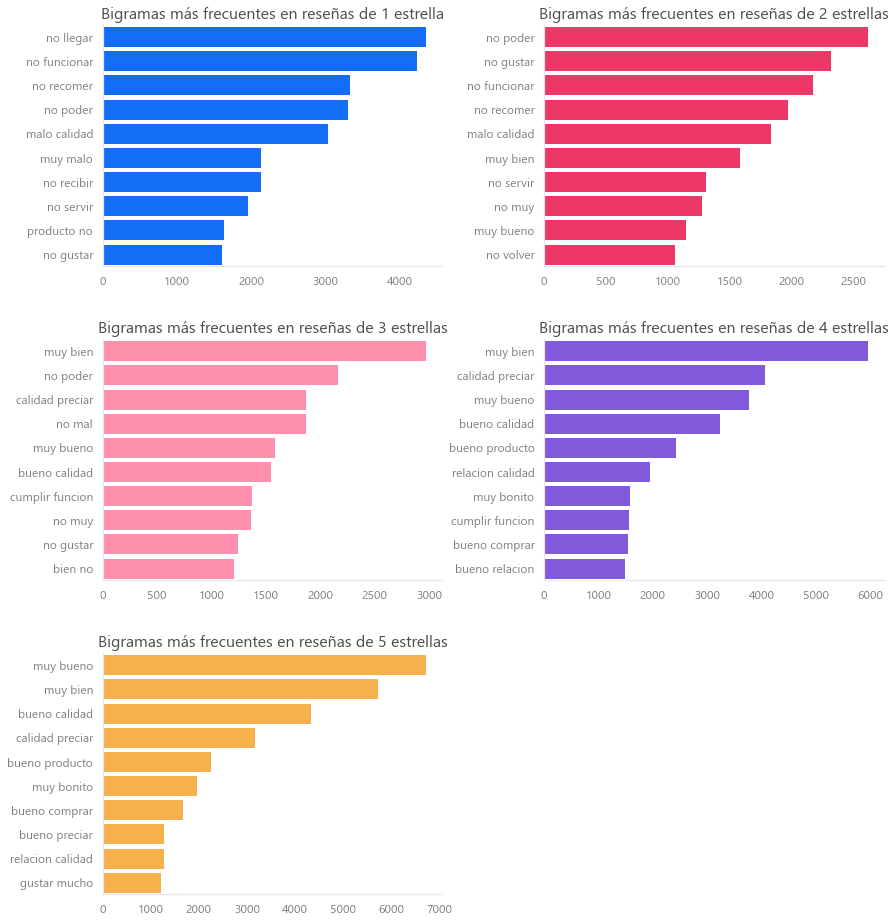

In [52]:
plt.figure(1, figsize=(14, 16))

stars = [1, 2, 3, 4, 5]

for i in stars:
    subset_ = subset.query('stars == {}'.format(i))
    reviews = []

    # Cargamos reseñas tokenizadas a la lista
    for j in range(subset_.shape[0]):
        review = subset_.iloc[j].clean_text
        review = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review)
        reviews.append(review)
    
    # 'Aplanamos' la lista
    reviews = list(itertools.chain(*reviews))
    
    # Sacamos los bigramas
    bigramas = nltk.bigrams(reviews)
    
    # Sacamos las frecuencias
    freq = nltk.FreqDist(bigramas)
    
    # Convertimos en DataFrame
    df_freq = pd.DataFrame(list(freq.items()), columns=["Bigram","Frequency"])
    df_freq.sort_values('Frequency', ascending=False, inplace=True)
    df_freq.reset_index(drop=True, inplace=True)
    df_freq['Bigram_text'] = list(' '.join(tupla) for tupla in df_freq['Bigram'].values)
    
    # Graficamos 
    plt.subplot(3, 2, i)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = sns.barplot(x=df_freq.iloc[:10].Frequency,
                     y=df_freq.iloc[:10].Bigram_text,
                     color=palette[i-1],
                     orient='h',
                     saturation=1)
    change_height(ax, 0.87)
    ax.set_title('Bigramas más frecuentes en reseñas de {} estrella{}'
                 .format(i, '' if i==1 else 's'))
    ax.set_xlabel('')
    ax.set_ylabel('')

<a id="2.4.3"></a>
### 2.4.3 Recuento de palabras

Del dataset podemos plantearnos algunas preguntas y resolverlas. La que intentaremos responder será:
> **¿La cantidad de palabras en las reseñas varía según el rating? <br> ¿Las de reseñas negativas tienen más texto o, por el contrario, las reseñas de personas satisfechas?**

La respuesta a esta pregunta nos podría dar indicios sobre si podemos usar esto como atributo para ingresar al modelo de machine learning.

In [53]:
subset['count_word'] = subset["full_text"].apply(lambda x: len(str(x).split()))

In [54]:
subset.count_word.describe()

count    200000.000000
mean         31.120780
std          24.817574
min           3.000000
25%          15.000000
50%          25.000000
75%          38.000000
max         566.000000
Name: count_word, dtype: float64

Las reseñas del dataset tienen en promedio **31 palabras** con una desviación estándar de 24. Ahora desagregamos por estrella:

In [55]:
mean_count_words = subset.groupby(by='stars').describe()
mean_count_words.columns = mean_count_words.columns.droplevel(0)
mean_count_words = mean_count_words.reset_index()
mean_count_words

,stars,count,mean,std,min,25%,50%,75%,max
0,1,40000.0,32.015575,23.804486,3.0,17.0,26.0,39.0,417.0
1,2,40000.0,35.005000,26.142413,3.0,19.0,28.0,43.0,511.0
2,3,40000.0,32.263400,25.348532,3.0,16.0,26.0,39.0,467.0
3,4,40000.0,28.936725,23.700470,3.0,14.0,23.0,35.0,398.0
4,5,40000.0,27.383200,24.276488,3.0,12.0,22.0,33.0,566.0


(0.0, 85.0)

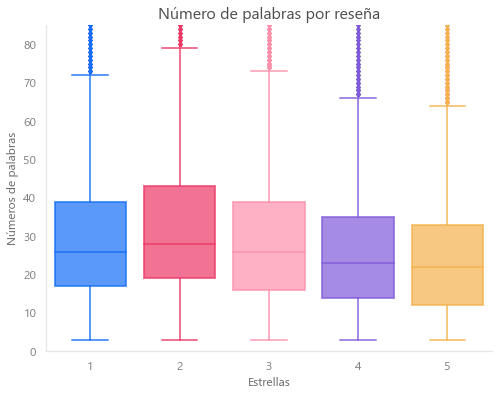

In [56]:
plt.figure(figsize=(8, 6))

ax = sns.boxplot(x=subset['stars'], 
                 y=subset['count_word'],
                 orient='v',
                 palette=palette,
                 saturation=1,
                 fliersize=3,
                 whis=1.5, 
                 linewidth=2, 
                 boxprops=dict(alpha=.7)
                )

color_boxplot(ax)
ax.set_title('Número de palabras por reseña')
ax.set_xlabel('Estrellas')
ax.set_ylabel('Números de palabras')
ax.set_ylim(0, 85)

Si bien la diferencia no es significativa, las estrellas 4 y 5 tienen menos palabras que el promedio general, por lo que podemos plantear la siguiente hipotesis: los clientes insatisfechos tienden a escribir más en las reseñas.

In [57]:
del subset
del subset_
del subset_neg
del subset_pos
del text
del text_neg
del text_pos
del freq
del df_freq
del reviews
del mean_rating
gc.collect()

20044

<a id="3"></a>
# 3. Modelado

<a id="3.1"></a>
## 3.1 Ingeniería de atributos

Podemos clasificar los atributos que podríamos usar en las siguientes dos categorías: 

**Atributos directos** <br>
Características que se deben directamente a las palabras o el contenido.
- Atributos relacionados con la frecuencia de palabras
    - Unigramas
    - Bigramas
    - Trigramas
- Polaridad generada al analizar el sentimiento


**Atributos indirectos** <br>
Estos son atributos más experimentales que pobraremos antes de llevarlas al modelo final. 

- Recuento de frases
- Recuento de palabras
- Recuento de palabras únicas
- Recuento de letras
- Recuento de signos de puntuación
- Recuento de palabras o letras en mayúsculas
- Recuento de stopwords
- Longitud media de cada palabra

<a id="3.1.1"></a>
### 3.1.1 Atributos indirectos

Primero crearemos los atributos indirectos debido a que los atributos directos son útiles solo si se crean a partir de un corpus limpio/procesado. Además, los atributos indirectos ayudan a compensar la pérdida de información al limpiar el dataset.

In [58]:
train = pd.read_csv('processed_data/train.csv')
dev = pd.read_csv('processed_data/dev.csv')
test = pd.read_csv('processed_data/test.csv')

In [59]:
X_train = train[['full_text']].copy()
X_dev = dev[['full_text']].copy()
y_train = train['stars'].values
y_dev = dev['stars'].values

**Recuentos de frase u oraciones**

In [60]:
# Recuento de oraciones en cada reseña
X_train['count_sent'] = X_train['full_text'].apply(lambda x: len(re.findall("\n",str(x)))+1)
X_train.count_sent.describe()

count    200000.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: count_sent, dtype: float64

No hay reviews con nuevas líneas que permitan diferenciar entre oraciones o parrafos. Revisemos alguna review con muchas palabras para ver qué sucede.

In [61]:
review = X_train[X_train["full_text"].apply(lambda x: len(str(x).split())) >= 500]['full_text'].iloc[0]
review

'Resultados regulares, sensor muy mejorable. Compré esta depiladora recomendada por una amiga que tiene una versión dos años anterior y ahora escribo después de usarla durante casi 5 MESES. Mi piel es completamente blanca y mi pelo negro, de manera que cumplo con el "pelo ideal" para la luz pulsada. Debo decir que SIEMPRE he usado la depiladora a potencia máxima 5 en todas las partes y jamás he notado molestias, mucho menos dolor. Sólo si llevas un larguísimo rato usándola y luego te la pones en la cara o bikini, tienes que tener cuidado que no sea demasiado caliente. He realizado el procedimiento de depilación en piernas, muslos, área del bikini, axilas y "bigote". Para no ser tan cargante y no dejarme media jornada en la tarea, me he depilado muslos y bikini la semana 1, piernas, axilas y bigote en la semana 2. Así que la tercera semana volvía a los muslos, la cuarta las piernas etc. He realizado un total de 8 sesiones en cada parte de manera continuada. He usado cuchilla para rasura

Al parecer las reseñas del dataset fueron procesadas para unir los parrafos, ya que las personas no suelen escribir textos tan largos sin presionar 'Enter'. Tendremos que sacar el número de frases a partir de los puntos seguidos.

In [62]:
len(re.findall(r'(\.\s|\:\s)', review))

25

Esa expresión regular nos servirá para encontrar puntos seguidos y dos puntos. Ahora a todo el dataset:

In [63]:
X_train['count_sent'] = X_train['full_text'].apply(lambda x: len(re.findall(r'(\.\s|\:\s)', str(x))))
X_train.count_sent.describe()

count    200000.000000
mean          2.092085
std           1.523908
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          51.000000
Name: count_sent, dtype: float64

**Recuentos de palabras, palabras únicas y letras**

In [64]:
# Número de palabras
X_train['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
# Número de palabras únicas 
X_train['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
# Número de letras
X_train['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))

X_train.describe()

,count_sent,count_word,count_unique_word,count_letters
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,2.092085,31.120780,26.328670,172.472740
std,1.523908,24.817574,17.541476,135.993737
min,1.000000,3.000000,2.000000,22.000000
25%,1.000000,15.000000,14.000000,87.000000
50%,2.000000,25.000000,23.000000,140.000000
75%,3.000000,38.000000,33.000000,210.000000
max,51.000000,566.000000,326.000000,3162.000000


**Recuentos de signos de puntuación, palabras en mayusculas y 'capitalizadas'**

In [65]:
# Número de signos de puntuación (¡!¿?)
X_train["count_punct"] = X_train["full_text"].apply(lambda x: len([c for c in str(x) if c in ['¡', '!', '¿', '?']]))
# Número de palabras en mayusculas
X_train["count_words_upper"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# Número de palabras con la primera letra en mayúscula
X_train["count_words_title"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

**Recuentos de stopwords y longitud promedio de las palabras**

In [66]:
# Número de stopwords
X_train["count_stopwords"] = X_train["full_text"].apply(lambda x: 
                             len([w for w in str(x).lower().split() if w in stopword_list]))

# Longitud promedio de las palabras
X_train["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

**Porcentaje de palabras unicas y porcentaje de signos puntuación**

In [67]:
#Word count percent in each comment:
X_train['word_unique_percent'] = X_train['count_unique_word']*100/X_train['count_word']

#Punct percent in each comment:
X_train['punct_percent'] = X_train['count_punct']*100/X_train['count_word']

X_train.describe()

,count_sent,count_word,count_unique_word,count_letters,count_punct,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,200000.000000,200000.000000
mean,2.092085,31.120780,26.328670,172.472740,0.146330,0.482215,3.043880,13.56879,4.691499,89.264743,0.608801
std,1.523908,24.817574,17.541476,135.993737,0.817595,3.061712,1.836149,12.14730,0.681082,9.291744,4.282033
min,1.000000,3.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.00000,1.750000,20.000000,0.000000
25%,1.000000,15.000000,14.000000,87.000000,0.000000,0.000000,2.000000,6.00000,4.259259,83.333333,0.000000
50%,2.000000,25.000000,23.000000,140.000000,0.000000,0.000000,3.000000,11.00000,4.594595,90.476190,0.000000
75%,3.000000,38.000000,33.000000,210.000000,0.000000,0.000000,4.000000,17.00000,5.000000,96.774194,0.000000
max,51.000000,566.000000,326.000000,3162.000000,74.000000,141.000000,52.000000,268.00000,12.750000,100.000000,740.000000


Aplicamos las mismas tranformaciones al set de Dev.

In [68]:
X_dev['count_sent'] = X_dev['full_text'].apply(lambda x: len(re.findall(r'(\.\s|\:\s)', str(x))))
X_dev['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
X_dev['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
X_dev['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
X_dev["count_punct"] = X_dev["full_text"].apply(lambda x: len([c for c in str(x) if c in ['¡', '!', '¿', '?']]))
X_dev["count_words_upper"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
X_dev["count_words_title"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
X_dev["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
X_dev["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
X_dev['word_unique_percent'] = X_dev['count_unique_word']*100/X_dev['count_word']
X_dev['punct_percent'] = X_dev['count_punct']*100/X_dev['count_word']

#### 3.1.1.1 Selección de atributos indirectos

Ahora veremos qué atributos son mejores predictores que otros. Para ello utilizaremos un modelo de Random Forest, y para evaluar utilizaremos el **accuracy** puesto hay que balance de clases y no hay un interés en predecir una clase en especial sino todas en general.

In [69]:
forest = RandomForestClassifier(max_depth=10,
                                max_features=2, 
                                min_samples_split=10,
                                min_samples_leaf=10,
                                n_jobs=-1,
                                random_state=100)

In [70]:
forest.fit(X_train.iloc[:, 1:], y_train)

RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=10,
                       min_samples_split=10, n_jobs=-1, random_state=100)

In [71]:
y_train_pred = forest.predict(X_train.iloc[:, 1:])
y_dev_pred = forest.predict(X_dev.iloc[:, 1:])

In [72]:
print('Accuracy en Train:', accuracy_score(y_train, y_train_pred))
print('Accuracy en Dev:', accuracy_score(y_dev, y_dev_pred))

Accuracy en Train: 0.30363
Accuracy en Dev: 0.2842


In [73]:
print(classification_report(y_dev, 
                            y_dev_pred, 
                            target_names=['1', '2', '3', '4', '5']))

              precision    recall  f1-score   support

           1       0.30      0.31      0.31      1000
           2       0.26      0.36      0.30      1000
           3       0.24      0.16      0.19      1000
           4       0.26      0.14      0.18      1000
           5       0.32      0.45      0.38      1000

    accuracy                           0.28      5000
   macro avg       0.28      0.28      0.27      5000
weighted avg       0.28      0.28      0.27      5000



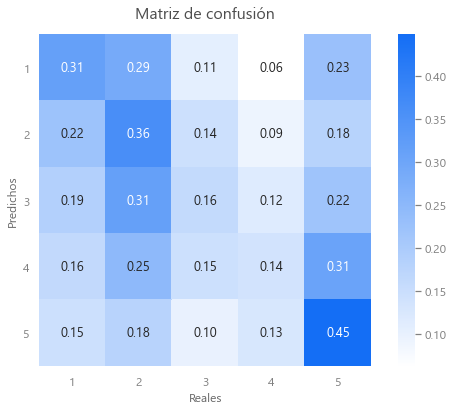

In [74]:
plt.figure(figsize=(8, 6))
conf = confusion_matrix(y_dev, y_dev_pred, labels=[1, 2, 3, 4, 5], normalize='true')
sns.heatmap(data = conf, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= [1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.xlabel('Reales')
plt.ylabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

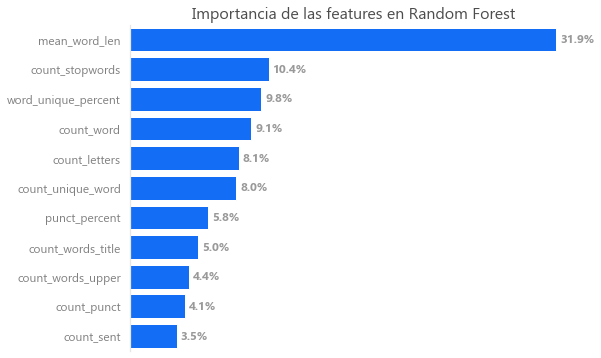

In [75]:
# Creamos el DataFrame
feature_names = X_train.iloc[:, 1:].columns
importances = forest.feature_importances_

feature_importances_forest = pd.DataFrame(importances,
                                          columns=['Coefficients'],
                                          index=feature_names)

feature_importances_forest.sort_values(by=['Coefficients'], 
                                       ascending=False, 
                                       inplace=True)

# Graficamos
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=feature_importances_forest.Coefficients, 
                 y=feature_importances_forest.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)
ax.set_title('Importancia de las features en Random Forest')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)
put_labels(feature_importances_forest.Coefficients, '{:.1%}')

Nos quedaremos con las features con las features de importacia >= 8%:
1. mean_word_len, 
2. count_stopwords, 
3. word_unique_percent, 
4. count_word, count_letters, 
5. count_unique_word.

In [76]:
del X_train
del X_dev
del y_train_pred
del y_dev_pred
gc.collect()

10864

<a id="3.1.2"></a>
### 3.1.2 Atributos directos

Ahora los atributos directos serán evaluados por separado: primero la vectorización de unigramas, luego la vectorización de bigramas y finalmente el análisis de sentimiento. Despues evaluaremos qué modelos y features funcionan mejor para este caso.

In [77]:
X_train = train[['clean_text']].copy()
X_dev = dev[['clean_text']].copy()

#### 3.1.2.1 Unigramas

In [78]:
vectorizer_unigrams = TfidfVectorizer(stop_words=stopword_cloud,
                                      ngram_range=(1, 1),
                                      min_df=100)

In [79]:
X_train_unigrams = vectorizer_unigrams.fit_transform(X_train['clean_text'].values)
X_dev_unigrams = vectorizer_unigrams.transform(X_dev['clean_text'].values)

In [80]:
print('Se vectorizaron {} features'.format(X_train_unigrams.shape[1]))

Se vectorizaron 2408 features


In [81]:
scaler = MaxAbsScaler()
X_train_unigrams = scaler.fit_transform(X_train_unigrams)
X_dev_unigrams = scaler.transform(X_dev_unigrams)

In [82]:
def benchmark(clf, X_train, X_dev, y_train, y_dev):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("Tiempo de entrenamiento: %0.3fs" % train_time)

    t0 = time()
    y_dev_pred = clf.predict(X_dev)
    dev_time = time() - t0
    print("Tiempo de prueba:  %0.3fs" % dev_time)

    score = accuracy_score(y_dev, y_dev_pred)
    print("Accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return [clf_descr, score, train_time, dev_time]

In [83]:
results = []


classifiers = ((MultinomialNB(alpha=0.01), "Multinomial NB"),
               (LinearSVC(penalty='l2', dual=False, tol=1e-3), "Linear SVC"),
               (PassiveAggressiveClassifier(max_iter=100), "Passive-Aggressive"),
               (SGDClassifier(alpha=0.0001, max_iter=100, penalty='l1'), "SGD Lasso"),
               (RidgeClassifier(tol=1e-3, solver="sag"), "Ridge Classifier"))
        
for clf, name in classifiers:
    print('=' * 80)
    print(name)
    results.append(benchmark(clf, X_train_unigrams, X_dev_unigrams, y_train, y_dev))

Multinomial NB
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
Tiempo de entrenamiento: 0.055s
Tiempo de prueba:  0.002s
Accuracy:   0.495

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
Tiempo de entrenamiento: 4.030s
Tiempo de prueba:  0.002s
Accuracy:   0.514

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=100)
Tiempo de entrenamiento: 2.522s
Tiempo de prueba:  0.001s
Accuracy:   0.443

SGD Lasso
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=100, penalty='l1')
Tiempo de entrenamiento: 2.934s
Tiempo de prueba:  0.001s
Accuracy:   0.449

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(s

C:\Users\dewit\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Tiempo de entrenamiento: 19.404s
Tiempo de prueba:  0.001s
Accuracy:   0.505



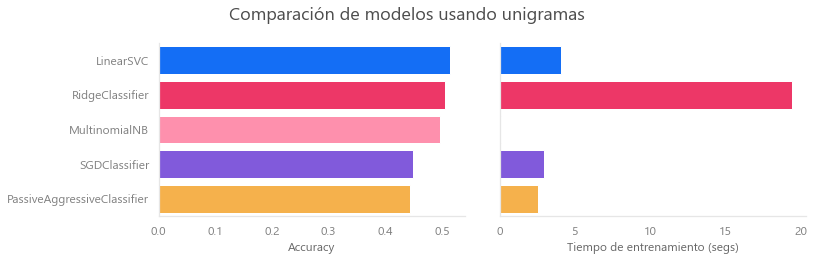

In [84]:
results = sorted(results, key= lambda x: x[1], reverse=True)
results_org = [[x[i] for x in results] for i in range(4)]

clf_names, scores, training_time, dev_time = results_org

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
fig.suptitle('Comparación de modelos usando unigramas', y=0.86, fontsize=18, fontweight='medium')
sns.barplot(x=scores, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax1)
ax1.set_xlabel('Accuracy')
sns.barplot(x=training_time, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax2)
ax2.set_xlabel('Tiempo de entrenamiento (segs)')
plt.tight_layout(pad=2)

#### 3.1.2.2 Unigramas + Bigramas

In [85]:
vectorizer_bigrams = TfidfVectorizer(ngram_range=(1, 2),
                                     min_df=100)

In [86]:
X_train_bigrams = vectorizer_bigrams.fit_transform(train_ml['clean_text'].values)
X_dev_bigrams = vectorizer_bigrams.transform(dev_ml['clean_text'].values)

In [87]:
print('Se vectorizaron {} features'.format(X_train_bigrams.shape[1]))

Se vectorizaron 4909 features


In [88]:
scaler = MaxAbsScaler()
X_train_bigrams = scaler.fit_transform(X_train_bigrams)
X_dev_bigrams = scaler.transform(X_dev_bigrams)

In [89]:
results_bi = []

classifiers = ((MultinomialNB(alpha=0.01), "Multinomial NB"),
               (LinearSVC(penalty='l2', dual=False, tol=1e-3), "Linear SVC"),
               (PassiveAggressiveClassifier(max_iter=100), "Passive-Aggressive"),
               (SGDClassifier(alpha=0.0001, max_iter=100, penalty='l1'), "SGD Lasso"),
               (RidgeClassifier(tol=1e-3, solver="sag"), "Ridge Classifier"))
        
for clf, name in classifiers:
    print('=' * 80)
    print(name)
    results_bi.append(benchmark(clf, X_train_bigrams, X_dev_bigrams, y_train, y_dev))

Multinomial NB
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
Tiempo de entrenamiento: 0.092s
Tiempo de prueba:  0.001s
Accuracy:   0.530

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
Tiempo de entrenamiento: 8.388s
Tiempo de prueba:  0.001s
Accuracy:   0.550

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=100)
Tiempo de entrenamiento: 2.663s
Tiempo de prueba:  0.002s
Accuracy:   0.471

SGD Lasso
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=100, penalty='l1')
Tiempo de entrenamiento: 3.304s
Tiempo de prueba:  0.002s
Accuracy:   0.477

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(s

C:\Users\dewit\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_ridge.py:556: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


Tiempo de entrenamiento: 21.728s
Tiempo de prueba:  0.002s
Accuracy:   0.543



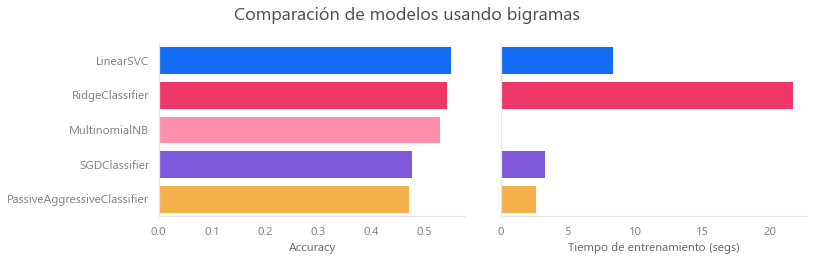

In [90]:
results_bi = sorted(results_bi, key= lambda x: x[1], reverse=True)
results_org = [[x[i] for x in results_bi] for i in range(4)]

clf_names, scores, training_time, dev_time = results_org

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
fig.suptitle('Comparación de modelos usando bigramas', y=0.86, fontsize=18, fontweight='medium')
sns.barplot(x=scores, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax1)
ax1.set_xlabel('Accuracy')
sns.barplot(x=training_time, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax2)
ax2.set_xlabel('Tiempo de entrenamiento (segs)')
plt.tight_layout(pad=2)

#### 3.1.2.3 Análisis de sentimiento

In [91]:
X_train = train[['full_text']].copy()
X_dev = dev[['full_text']].copy()
X_test = test[['full_text']].copy()

In [92]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

x = "Recomendado, vino en perfectas condiciones el producto"

print(x + ' ==> %.5f' % sentiment.sentiment(x))

Recomendado, vino en perfectas condiciones el producto ==> 0.89894


In [93]:
pol = lambda x: sentiment.sentiment(x) # función para predecir polaridad
bins = [0, 0.3, 0.7, 1] # para el pandas cut
labels = ['pol_neg', 'pol_neu', 'pol_pos'] # nombres para bines

In [94]:
try:
    X_train_polarity = pd.read_csv('processed_data/train_polarity.csv')
except:
    X_train_polarity['polarity'] = X_train['full_text'].apply(pol)
    X_train_polarity['polarity_binned'] = pd.cut(X_train['polarity'], 
                                                 bins=bins, 
                                                 labels=labels)
    X_train_polarity = pd.concat([X_train_polarity['polarity'], 
                                  pd.get_dummies(X_train_polarity['polarity_binned'])], 
                                 axis=1)

In [95]:
try:
    X_dev_polarity = pd.read_csv('processed_data/dev_polarity.csv')
except:
    X_dev_polarity['polarity'] = X_dev['full_text'].apply(pol)
    X_dev_polarity['polarity_binned'] = pd.cut(X_dev['polarity'], 
                                                 bins=bins, 
                                                 labels=labels)
    X_dev_polarity = pd.concat([X_dev_polarity['polarity'], 
                                  pd.get_dummies(X_dev_polarity['polarity_binned'])], 
                                 axis=1)

In [96]:
try:
    X_test_polarity = pd.read_csv('processed_data/test_polarity.csv')
except:
    X_test_polarity['polarity'] = X_test['full_text'].apply(pol)
    X_test_polarity['polarity_binned'] = pd.cut(X_test['polarity'], 
                                                 bins=bins, 
                                                 labels=labels)
    X_test_polarity = pd.concat([X_test_polarity['polarity'], 
                                  pd.get_dummies(X_test_polarity['polarity_binned'])], 
                                 axis=1)

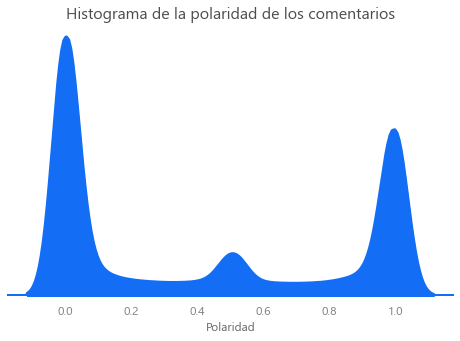

In [97]:
plt.figure(figsize=(8, 5))
sns.kdeplot(X_train_polarity.polarity, 
            shade=True, 
            alpha=1, 
            lw=2, 
            color=blue, 
            legend=False)
sns.kdeplot(X_train_polarity.polarity, 
            lw=4, 
            color=blue, 
            legend=False)
plt.axhline(y=0, lw=4)

plt.title('Histograma de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('')
plt.yticks(())
sns.despine(left=True, bottom=True)

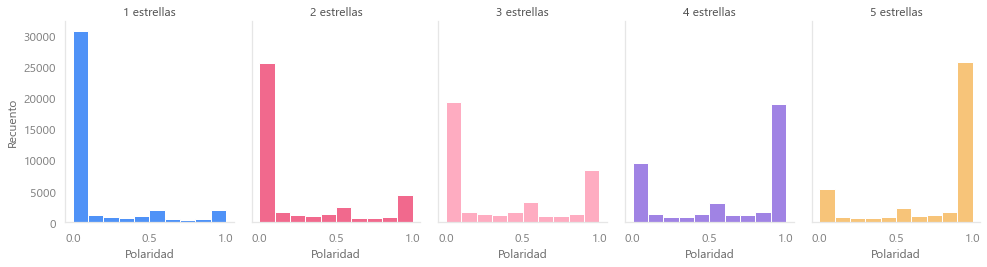

In [98]:
g = sns.displot(data=X_train_polarity, 
                x='polarity', 
                hue=y_train, 
                col=y_train, 
                kind='hist',
                palette=palette[:5],
                height=4, 
                aspect=0.7,
                legend=False, 
                bins=10)

g.set_axis_labels("Polaridad", "Recuento")
g.set_titles("{col_name} estrellas")

Ahora evaluamos su performance

In [99]:
results_sentiment = []

classifiers = ((MultinomialNB(alpha=0.01), "Multinomial NB"),
               (LinearSVC(penalty='l2', dual=False, tol=1e-3), "Linear SVC"),
               (PassiveAggressiveClassifier(max_iter=100), "Passive-Aggressive"),
               (SGDClassifier(alpha=0.0001, max_iter=100, penalty='l1'), "SGD Lasso"),
               (RidgeClassifier(tol=1e-3, solver="sag"), "Ridge Classifier"))
        
for clf, name in classifiers:
    print('=' * 80)
    print(name)
    results_sentiment.append(benchmark(clf, X_train_polarity, X_dev_polarity, y_train, y_dev))

Multinomial NB
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
Tiempo de entrenamiento: 0.049s
Tiempo de prueba:  0.003s
Accuracy:   0.341

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(dual=False, tol=0.001)
Tiempo de entrenamiento: 0.414s
Tiempo de prueba:  0.004s
Accuracy:   0.346

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=100)
Tiempo de entrenamiento: 1.296s
Tiempo de prueba:  0.004s
Accuracy:   0.286

SGD Lasso
________________________________________________________________________________
Training: 
SGDClassifier(max_iter=100, penalty='l1')
Tiempo de entrenamiento: 1.888s
Tiempo de prueba:  0.003s
Accuracy:   0.221

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(s

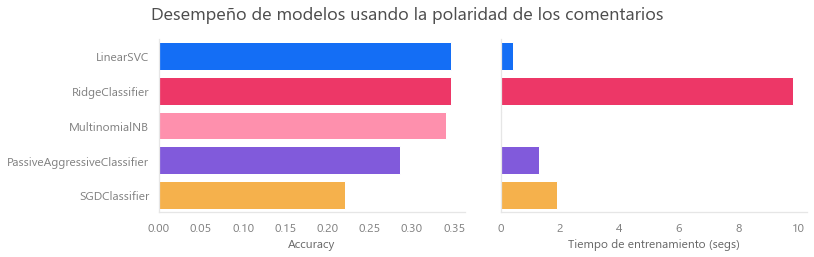

In [100]:
results_sentiment = sorted(results_sentiment, key= lambda x: x[1], reverse=True)
results_org = [[x[i] for x in results_sentiment] for i in range(4)]

clf_names, scores, training_time, test_time = results_org

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)
fig.suptitle('Desempeño de modelos usando la polaridad de los comentarios', y=0.85, fontsize=18, fontweight='medium')
sns.barplot(x=scores, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax1)
ax1.set_xlabel('Accuracy')
sns.barplot(x=training_time, y=clf_names, palette=palette, orient='h', saturation=1, ax=ax2)
ax2.set_xlabel('Tiempo de entrenamiento (segs)')
plt.tight_layout(pad=2)

In [101]:
sentiment_svc = LinearSVC(penalty='l2', dual=False, tol=1e-3)
sentiment_svc.fit(X_train_polarity, y_train)
y_train_pred = sentiment_svc.predict(X_train_polarity)
y_dev_pred = sentiment_svc.predict(X_dev_polarity)

print('Accuracy en Train:', accuracy_score(y_train, y_train_pred))
print('Accuracy en Dev:', accuracy_score(y_dev, y_dev_pred))

Accuracy en Train: 0.343
Accuracy en Dev: 0.3458


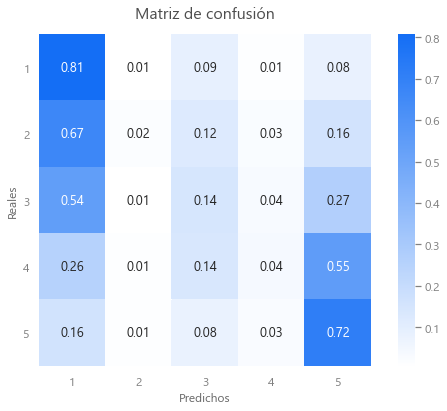

In [102]:
plt.figure(figsize=(8, 6))
conf_sent = confusion_matrix(y_dev, y_dev_pred, labels=[1, 2, 3, 4, 5], normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= [1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

<a id="3.2"></a>
## 3.2 Modelo final

Para el modelo final combinaremos los features antes vistos. Empezaremos extrayendo los unigramas y bigramas.

In [103]:
train = pd.read_csv('processed_data/train.csv')
dev = pd.read_csv('processed_data/dev.csv')
test = pd.read_csv('processed_data/test.csv')

In [104]:
X_train = train[['full_text', 'clean_text']].copy()
X_dev = dev[['full_text', 'clean_text']].copy()
X_test = test[['full_text', 'clean_text']].copy()

In [105]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, dtype=np.float32)

train_ngrams =  vectorizer.fit_transform(X_train['clean_text'])
dev_ngrams = vectorizer.transform(X_dev['clean_text'])
test_ngrams = vectorizer.transform(X_test['clean_text'])

# Obtenemos los nombres de las features
features_ngrams = np.array(vectorizer.get_feature_names())

Ahora extraemos las features indirectas:
mean_word_len,
count_stopwords,
word_unique_percent,
count_word, count_letters,
count_unique_word.

In [106]:
stopword_list = nltk.corpus.stopwords.words('spanish')

In [107]:
train_indirect = pd.DataFrame()
train_indirect['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
train_indirect['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))
train_indirect['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
train_indirect["count_stopwords"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
train_indirect["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_indirect['word_unique_percent'] = train_indirect['count_unique_word']*100/train_indirect['count_word']

In [108]:
dev_indirect = pd.DataFrame()
dev_indirect['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
dev_indirect['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
dev_indirect['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
dev_indirect["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
dev_indirect["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
dev_indirect['word_unique_percent'] = dev_indirect['count_unique_word']*100/dev_indirect['count_word']

In [109]:
test_indirect = pd.DataFrame()
test_indirect['count_word'] = X_test['full_text'].apply(lambda x: len(str(x).split()))
test_indirect['count_letters'] = X_test['full_text'].apply(lambda x: len(str(x)))
test_indirect['count_unique_word'] = X_test['full_text'].apply(lambda x: len(set(str(x).split())))
test_indirect["count_stopwords"] = X_test["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
test_indirect["mean_word_len"] = X_test["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_indirect['word_unique_percent'] = test_indirect['count_unique_word']*100/test_indirect['count_word']

Leemos los datasets de polaridad

In [110]:
train_polarity = pd.read_csv('processed_data/train_polarity.csv')
dev_polarity = pd.read_csv('processed_data/dev_polarity.csv')
test_polarity = pd.read_csv('processed_data/test_polarity.csv')

Solo falta juntar todas las features en un matriz dispersa

In [111]:
X_train = hstack((train_ngrams, train_indirect,  train_polarity)).tocsr()
X_dev = hstack((dev_ngrams, dev_indirect,  dev_polarity)).tocsr()
X_test = hstack((test_ngrams, test_indirect,  test_polarity)).tocsr()

*target y*

In [112]:
y_train = train['stars'].values
y_dev = dev['stars'].values
y_test = test['stars'].values

*target y* multilabel

In [113]:
# Train 
y_train_multi = pd.DataFrame(data=np.zeros((train.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_train_multi.iloc[:, i] = np.array(train.stars == i+1).astype(int)
    
# Dev
y_dev_multi = pd.DataFrame(data=np.zeros((dev.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_dev_multi.iloc[:, i] = np.array(dev.stars == i+1).astype(int)

# Test
y_test_multi = pd.DataFrame(data=np.zeros((test.shape[0], 5)).astype(int), columns=[1, 2, 3, 4, 5])
for i in range(5):
    y_test_multi.iloc[:, i] = np.array(test.stars == i+1).astype(int)

<a id="3.2.1"></a>
### 3.2.1 Benchmark

Nuestro modelo de comparación será un clasificador tonto: predice aleatoriamente los valores de la lcases teniendo en cuenta su distribución en el set de entrenamiento.

In [114]:
benchmark = DummyClassifier(strategy='prior')
benchmark.fit(X_train, y_train)

DummyClassifier(strategy='prior')

In [115]:
y_train_pred_bench = benchmark.predict(X_train)
y_dev_pred_bench = benchmark.predict(X_dev)
y_test_pred_bench = benchmark.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_bench))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_bench))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_bench), '<---')

Accuracy en el set de Train: 0.2
Accuracy en el set de Dev: 0.2
Accuracy en el set de Test: 0.2 <---


<a id="3.2.1"></a>
### 3.2.1 NBSVM

Para el modelo final usaremos NBSVM (Naive Bayes - Support Vector Machine). El algoritmo fue presentado por Sida Wang y Chris Manning en el artículo [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).

Cretidos a [AlexSanchez](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline-eda-0-052-lb#261316) por la implementación en python para la competición de Kaggle, *Toxic Comment Classification Challenge*.

In [116]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted

In [117]:
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))
                            
    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [118]:
stars = [1, 2, 3, 4, 5]

# Métricas
auc_train = []
auc_dev = []
auc_test = []

# Predcciones de probabilidades
y_train_pred_prob = np.zeros((X_train.shape[0], y_train_multi.shape[1]))
y_dev_pred_prob = np.zeros((X_dev.shape[0], y_dev_multi.shape[1]))
y_test_pred_prob = np.zeros((X_test.shape[0], y_test_multi.shape[1]))

for i, j in enumerate(stars):
    print ('Estrella {}'.format(i+1))
    
    #Entrenamos
    nbsvm = NbSvmClassifier(C=4, dual=False, n_jobs=-1)
    nbsvm.fit(X_train, y_train_multi.iloc[:, i]) 
    
    #Predecimos la probabilidad
    y_train_pred_prob[:, i] = nbsvm.predict_proba(X_train)[:, 1]
    y_dev_pred_prob[:, i] = nbsvm.predict_proba(X_dev)[:, 1]
    y_test_pred_prob[:, i] = nbsvm.predict_proba(X_test)[:, 1]
    
    #Hallamos el área bajo la curva de cada estrella
    auc_train_star = roc_auc_score(y_train_multi[j], y_train_pred_prob[:, i])
    auc_dev_star = roc_auc_score(y_dev_multi[j], y_dev_pred_prob[:, i])
    auc_test_star = roc_auc_score(y_test_multi[j], y_test_pred_prob[:, i])   
    
    print('ROC-AUC en train: {:.3f}'.format(auc_train_star))
    print('ROC-AUC en dev: {:.3f}'.format(auc_dev_star))
    print('ROC-AUC en test: {:.3f} <--'.format(auc_test_star))
    
    auc_train.append(auc_train_star)
    auc_dev.append(auc_dev_star)
    auc_test.append(auc_test_star)
    print('='*60)

print()
print('ROC-AUC promedio en el set de Train:', np.mean(auc_train))
print('ROC-AUC promedio en el set de Dev:', np.mean(auc_dev))
print('ROC-AUC promedio en el set de Test:', np.mean(auc_test), '<---')

Estrella 1
ROC-AUC en train: 0.931
ROC-AUC en dev: 0.929
ROC-AUC en test: 0.930 <--
Estrella 2
ROC-AUC en train: 0.787
ROC-AUC en dev: 0.777
ROC-AUC en test: 0.785 <--
Estrella 3
ROC-AUC en train: 0.764
ROC-AUC en dev: 0.749
ROC-AUC en test: 0.771 <--
Estrella 4
ROC-AUC en train: 0.794
ROC-AUC en dev: 0.786
ROC-AUC en test: 0.799 <--
Estrella 5
ROC-AUC en train: 0.897
ROC-AUC en dev: 0.891
ROC-AUC en test: 0.893 <--

ROC-AUC promedio en el set de Train: 0.8346664331874999
ROC-AUC promedio en el set de Dev: 0.82650515
ROC-AUC promedio en el set de Test: 0.8356419500000001 <---


In [119]:
y_train_pred_nbsvm = pd.DataFrame(data=y_train_pred_prob, columns=stars).idxmax(axis=1)
y_dev_pred_nbsvm = pd.DataFrame(data=y_dev_pred_prob, columns=stars).idxmax(axis=1)
y_test_pred_nbsvm = pd.DataFrame(data=y_test_pred_prob, columns=stars).idxmax(axis=1)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_nbsvm))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_nbsvm))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_nbsvm), '<---')

Accuracy en el set de Train: 0.54818
Accuracy en el set de Dev: 0.5394
Accuracy en el set de Test: 0.5526 <---


<a id="3.2.2"></a>
### 3.2.2 Linear SVC

In [120]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

In [121]:
svc.fit(X_train, y_train)

LinearSVC(C=0.01, dual=False)

In [122]:
y_train_pred_svc = svc.predict(X_train)
y_dev_pred_svc = svc.predict(X_dev)
y_test_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_svc), '<---')

Accuracy en el set de Train: 0.55781
Accuracy en el set de Dev: 0.544
Accuracy en el set de Test: 0.5552 <---


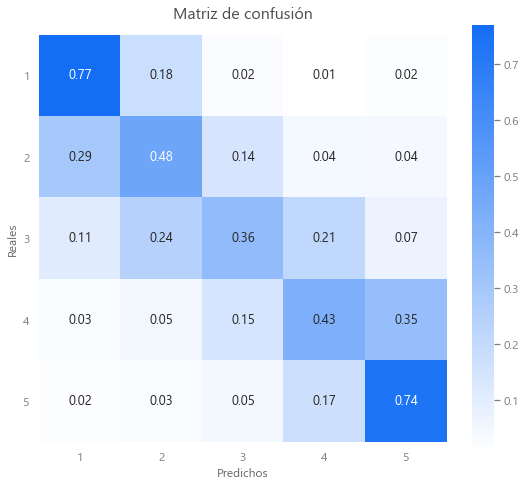

In [123]:
plt.figure(figsize=(8, 7))
conf_sent = confusion_matrix(y_test, y_test_pred_svc, 
                             labels=[1, 2, 3, 4, 5], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels = [1, 2, 3, 4, 5], 
            yticklabels = [1, 2, 3, 4, 5], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

## 3.3 Resultados

In [124]:
# Creamos el DataFrame de los coeficientes
columns = np.concatenate((features_ngrams, train_indirect.columns, train_polarity.columns))
coeff = svc.coef_
coeff_svc = pd.DataFrame(coeff, columns=columns, index=[1, 2, 3, 4, 5])
mean_coeff_column = coeff_svc.mean().abs().sort_values(ascending=False)[:15]

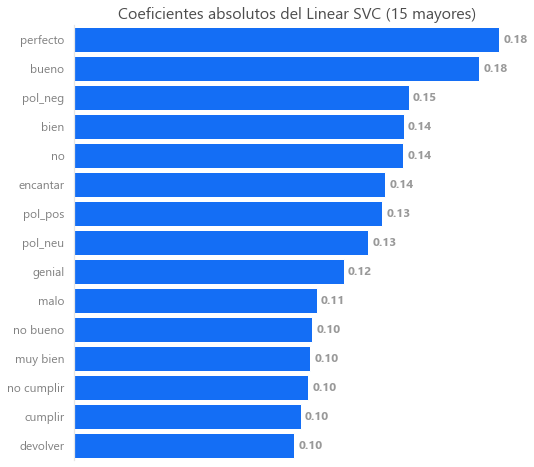

In [125]:
# Graficamos
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=mean_coeff_column.values, 
                 y=mean_coeff_column.index,
                 color=blue, 
                 orient='h', 
                 saturation=1)
ax.set_title('Coeficientes absolutos del Linear SVC (15 mayores)')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks(())
sns.despine(bottom=True)
put_labels(mean_coeff_column.values, '{:.2f}', 12.2)
change_height(ax, 0.87)

Con la parte de modelado pudimos obtener un accuracy de 0.55 en test, lo cual no es un rendimeinto especialmente alto. El modeladoelo que mejor desempeño tuvo fue Linear SVC por muy poco. Con el análisis de los coeficientes notamos que las features más importantes para este modelo son las relacionadas con la polaridad y algunas del corpus en sí: perfecto, bueno, bien, genial, malo, no bueno, cumplir - no cumplir, devolver, etc.


<a id="4"></a>
# 4. Próximos pasos

Para mejorar el proyecto actual sería conveniente reformar el problema, puesto que aunque se prueben otros algoritmos de machine learning el resultado no cambiará mucho. 

Si lo que se quiere es clasificar reviews de personas que se siente satisfechas con un producto en contraste a las personas a las que el producto no cumplió sus expectativas, lo mejor sería simplicar el problema a una clasficiación binaria. Es decir, que el modelo prediga si el comentario es positivo o negativo. Y esto proveería más información sobre la calidad o satisfacción general que tiene producto.

Luego de simplicar el problema se puede probar mejorar el rendimeinto probando otros modelos de ML o incluso una Neural Network.

Predecimos manteniendo 3 clases: negativo, neutro y postivo.

In [126]:
def binarize_tri(x):
    if x == 4 or x == 5:
        return 2
    elif x ==3:
        return 1
    else:
        return 0
    
y_train_tri = train['stars'].apply(binarize_tri)
y_dev_tri = dev['stars'].apply(binarize_tri)
y_test_tri = test['stars'].apply(binarize_tri)

In [127]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train_tri)

y_train_tri_pred_svc = svc.predict(X_train)
y_dev_tri_pred_svc = svc.predict(X_dev)
y_test_tri_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train_tri, y_train_tri_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev_tri, y_dev_tri_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test_tri, y_test_tri_pred_svc), '<---')

Accuracy en el set de Train: 0.753405
Accuracy en el set de Dev: 0.7466
Accuracy en el set de Test: 0.7482 <---


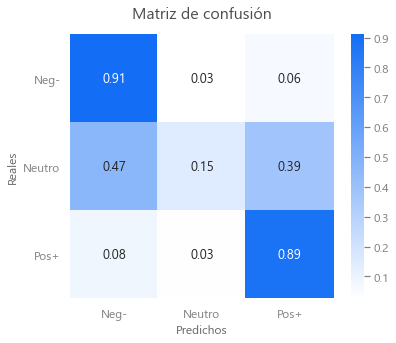

In [128]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test_tri, y_test_tri_pred_svc, 
                             labels=[0, 1, 2], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Neutro', 'Pos+'], 
            yticklabels=['Neg-', 'Neutro', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Predecimos manteniendo solo 2 clases: negativo y postivo. Convertirmos las reviews con 3 estrellas en _negativo_.

In [129]:
def binarize_bi(x):
    if x == 4 or x == 5:
        return 1
    else:
        return 0
    
y_train_bi = train['stars'].apply(binarize_bi)
y_dev_bi = dev['stars'].apply(binarize_bi)
y_test_bi = test['stars'].apply(binarize_bi)

In [130]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train_bi)

y_train_bi_pred_svc = svc.predict(X_train)
y_dev_bi_pred_svc = svc.predict(X_dev)
y_test_bi_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train_bi, y_train_bi_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev_bi, y_dev_bi_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test_bi, y_test_bi_pred_svc), '<---')

Accuracy en el set de Train: 0.86784
Accuracy en el set de Dev: 0.8662
Accuracy en el set de Test: 0.8622 <---


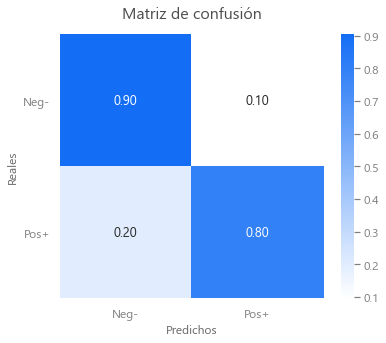

In [131]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test_bi, y_test_bi_pred_svc, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

Como se evidencia en la prueba, manejar solo dos clases hace que el performance se incremente considerablemente.